In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision
import time
import os
import copy
import PIL

from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision import datasets, models, transforms

from PIL import Image
from torch.utils.data import WeightedRandomSampler
from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings 
warnings.filterwarnings('ignore')


The emergence of infectious diseases with pandemic potential has served as a wake-up call to various governments across the globe. Througout human history, the biological threat of a pandemic disease has been devastating on an unprecedented scale, as evidenced by diseases such as COVID-19, influenza, and the bubonic plague. Because of these risks, the rapid spread of the Monkeypox disease this year has posed another global threat during COVID-19 pandemic. The Monkeypox, primarily caused by the monkeypox virus, is an infectious zoonotic disease which is closely related to smallpox but with milder infection. The World Health Organization (WHO) already declared the Monkeypox outbreak an international public health emergency, citing with a staggering increase of 30,000 cases worldwide. While the WHO has not declared the monkeypox oubreak a pandemic, several epidemiologists have highlighted the severity of monkeypox disease infection among the human population.

The transmission of monkeypox virus occurs when a person comes into contact with an infected animal or human. The virus is highly susceptible (i.e., able to contract the disease) to various animal species, particularly on non-human primates (e.g. monkeys). Animal-to-human transmission occurs primarily when infected monkeys transmit the monkeypox virus via bite, scratch, or even contaminated monkey meat preparation. Human-to-human transmission also occurs when infected humans pass the virus on to other people through direct contact with bodily fluids (i.e., sweat, semen, blood). Those who are susceptible can be exposed to the virus (i.e., have been infected but are not yet infectious) and will become infected (i.e., capable of transmitting the disease to other humans) at any time. Unfortunately, there is no known monkeypox vaccine in circulation, but smallpox vaccine may be used as a protection against Monkeypox with 85% effectivity. Nonetheless, while most infected people may recover from Monkeypox, the WHO highly recommends infected patients to take vaccine, especially if symptoms are severe.

In [2]:
folder_train, folder_valid, folder_tests = 'D:/mpox/data/images/train/', 'D:/mpox/data/images/valid/', 'D:/mpox/data/images/test/'
def get_images_path(folder):
    path_list = []
    image_files = [file for file in os.listdir(folder) if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png')]
    image_files = [path_list.append(folder + file) for file in image_files]
    return path_list
path_list_train, path_list_valid, path_list_tests = get_images_path(folder_train), get_images_path(folder_valid), get_images_path(folder_tests)

def get_images_table(path_list_train):
    df = pd.DataFrame(path_list_train)
    df = df.rename(columns = {0: 'filepath'})
    df['names'] = [string.split('/')[-1].split('.')[0] for string in df['filepath']]
    df['label'] = [string.split('/')[-1].split('_')[0] for string in df['filepath']]
    df['split'] = [string.split('/')[4] for string in df['filepath']]
    df = df.drop_duplicates(subset = 'names') 
    return df

df_train, df_valid, df_tests = get_images_table(path_list_train), get_images_table(path_list_valid), get_images_table(path_list_tests)
df_main = pd.concat([df_train, df_valid, df_tests], axis = 0)
execute = True
if execute:
    df_main = df_main.drop_duplicates(subset = 'names', keep = 'first')

encoder = LabelEncoder()
df_main['label'] = encoder.fit_transform(df_main['label']) 
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

In [3]:
def get_label_file(df_main, split):
    df = df_main[df_main['split'] == split]
    df['image'] = [string[19:] for string in df['filepath']]
    df = df[['image', 'label']]
    return df
get_label_file(df_main, 'train').to_csv('D:/mpox/data/labels/trainlabels.txt', index = False, sep = ' ')
get_label_file(df_main, 'valid').to_csv('D:/mpox/data/labels/validlabels.txt', index = False, sep = ' ')
get_label_file(df_main, 'test') .to_csv('D:/mpox/data/labels/testslabels.txt', index = False, sep = ' ')

In [4]:
class MonkeyPoxDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, image_path, transforms = None):    
        ''' 
        Arguments:
             data_path (string): Directory of all the datasets
            image_path (string): Path to the image files. It should be either train, val, or test
            transform  (callable, option): Optional transfrom to be applied on an image for data augmentation
        '''
        self.transform  = transforms
        self.data_path  = data_path
        self.images_dir = data_path / 'images' / Path(image_path)

        if   image_path == 'train': 
            self.labels_dir = data_path / 'labels' / 'trainlabels.txt'
        elif image_path == 'valid':
            self.labels_dir = data_path / 'labels' / 'validlabels.txt'
        elif image_path == 'test' :
            self.labels_dir = data_path / 'labels' / 'testslabels.txt'
        self.dataset = self._load_data(self.images_dir, self.labels_dir)

    def __getitem__(self, index):
        dataset  = self.dataset
        img_path = self.images_dir / dataset[index][0]
        with open(img_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        label = dataset[index][1]
        return self.transform(image), label

    def __len__(self):
        return len(self.dataset) 

    def _load_data(self, images_dir, labels_file):
        with open(labels_file, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines[1:]:
            filename, label = line.strip().split()
            filename = os.path.basename(filename)
            label = int(label)
            data.append((filename, label))
        return data
    
train_transform =   transforms.Compose([
                    transforms.RandomRotation(10),      
                    transforms.RandomHorizontalFlip(),  
                    transforms.Resize((32, 32)),                 
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

valid_transform =   transforms.Compose([
                    transforms.Resize((32, 32)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

data_path  = Path('D:/mpox/data/')
train_dataset  = MonkeyPoxDataset(data_path, image_path = 'train', transforms = train_transform)
valid_dataset  = MonkeyPoxDataset(data_path, image_path = 'valid', transforms = valid_transform)
test_dataset   = MonkeyPoxDataset(data_path, image_path = 'test',  transforms = valid_transform)

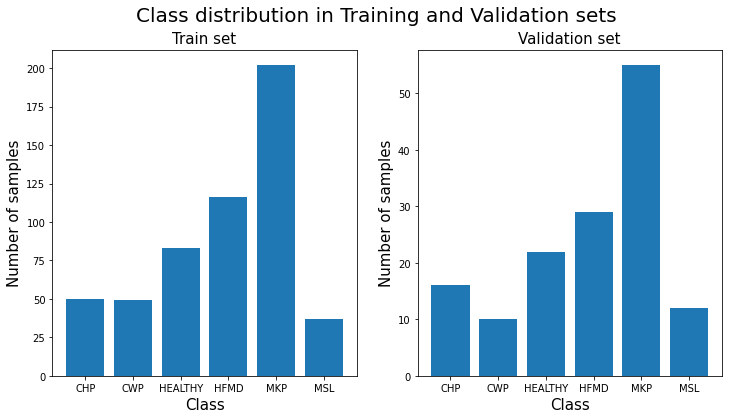

In [5]:
def check_imbalance(dataset):
    ''' 
    Counts the number of samples in every class for a given dataset
    Arguments:
        dataset 
    Returns: 
        tuple (value for class 0, value for class 1)
    '''
    classes = [label for _,   label in dataset]
    index_0 = len([idx   for idx, label in enumerate(classes) if label == 0])
    index_1 = len([idx   for idx, label in enumerate(classes) if label == 1])
    index_2 = len([idx   for idx, label in enumerate(classes) if label == 2])
    index_3 = len([idx   for idx, label in enumerate(classes) if label == 3])
    index_4 = len([idx   for idx, label in enumerate(classes) if label == 4])
    index_5 = len([idx   for idx, label in enumerate(classes) if label == 5])
    return index_0, index_1, index_2, index_3, index_4, index_5 

def plot_imbalance(train_dataset, valid_dataset):
    ''' 
    Creates the subplots and plots the class distribution
    '''
    class_count_train = check_imbalance(train_dataset)
    class_count_valid = check_imbalance(valid_dataset)

    fig, axs = plt.subplots(1, 2, figsize = (12, 6))
    fig.suptitle('Class distribution in Training and Validation sets', size = 20)
    labels = ['CHP', 'CWP', 'HEALTHY', 'HFMD', 'MKP', 'MSL']

    axs[0].bar(labels, class_count_train)
    axs[0].set_title('Train set', size = 15)
    axs[0].set_xlabel('Class', size = 15)
    axs[0].set_ylabel('Number of samples', size = 15)

    axs[1].bar(labels, class_count_valid)
    axs[1].set_title('Validation set', size = 15)
    axs[1].set_xlabel('Class', size = 15)
    axs[1].set_ylabel('Number of samples', size = 15)
    plt.show()

plot_imbalance(train_dataset, valid_dataset)

<BarContainer object of 3 artists>

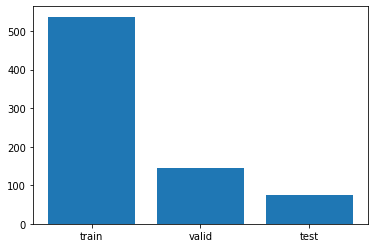

In [6]:
plt.bar(x = ['train', 'valid', 'test'], height = df_main['split'].value_counts())

In [7]:
 df_main['split'].value_counts()

train    537
valid    144
test      74
Name: split, dtype: int64

In [8]:
def get_sampler(dataset):
    '''  
    Description: Get weighted samples using Weighted Random Sampler
        Arguments:
            dataset: Any imbalanced dataset that requires oversampling
        Returns:
            dataset used with Weighted Random Sampler
    '''
    classes = [label for _,   label in dataset]
    index_0 = [idx   for idx, label in enumerate(classes) if label == 0]
    index_1 = [idx   for idx, label in enumerate(classes) if label == 1]
    index_2 = [idx   for idx, label in enumerate(classes) if label == 2]
    index_3 = [idx   for idx, label in enumerate(classes) if label == 3]
    index_4 = [idx   for idx, label in enumerate(classes) if label == 4]
    index_5 = [idx   for idx, label in enumerate(classes) if label == 5]
    
    weights = torch.zeros(len(index_0) + len(index_1) + len(index_2) + len(index_3) + len(index_4) + len(index_5))
    weights[index_0] = 1.0 / len(index_0)
    weights[index_1] = 1.0 / len(index_1)
    weights[index_2] = 1.0 / len(index_2)
    weights[index_3] = 1.0 / len(index_3)
    weights[index_4] = 1.0 / len(index_4)
    weights[index_5] = 1.0 / len(index_5)

    sampler = WeightedRandomSampler(weights = weights, num_samples = len(weights), replacement = True)
    return sampler

torch.manual_seed(42)
train_sampler = get_sampler(train_dataset)
valid_sampler = get_sampler(valid_dataset)

train_loader   = DataLoader(train_dataset, batch_size = 32, sampler = train_sampler)
valid_loader   = DataLoader(valid_dataset, batch_size = 32, sampler = valid_sampler)
test_loader    = DataLoader(test_dataset,  batch_size = 32, shuffle = False)

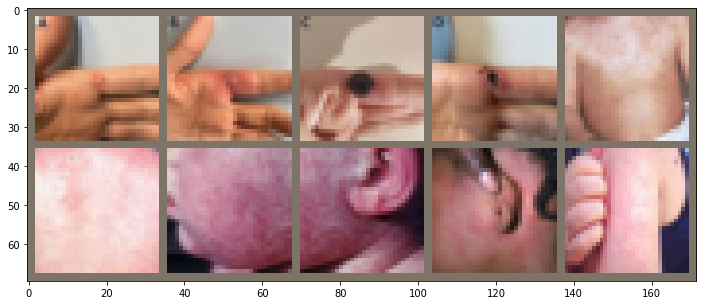

In [9]:
for idx, (image, label) in enumerate(test_loader):
    if idx == 5:
        break
im = make_grid(image, nrow = 5) 
inv_normalize = transforms.Normalize(
                    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std  = [1/0.229, 1/0.224, 1/0.225])
im_inv = inv_normalize(im)
plt.figure(figsize = (12, 7))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [10]:
for images, labels in train_loader:
    break
class_names = ['CHP', 'CWP', 'HEALTHY', 'HFMD', 'MKP', 'MSL'] 

print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

Label: [3 5 2 1 3 5 3 3 2 3 4 1 1 1 4 2 1 2 5 3 2 5 0 1 4 0 0 1 5 4 1 3]
Class:  HFMD MSL HEALTHY CWP HFMD MSL HFMD HFMD HEALTHY HFMD MKP CWP CWP CWP MKP HEALTHY CWP HEALTHY MSL HFMD HEALTHY MSL CHP CWP MKP CHP CHP CWP MSL MKP CWP HFMD


saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


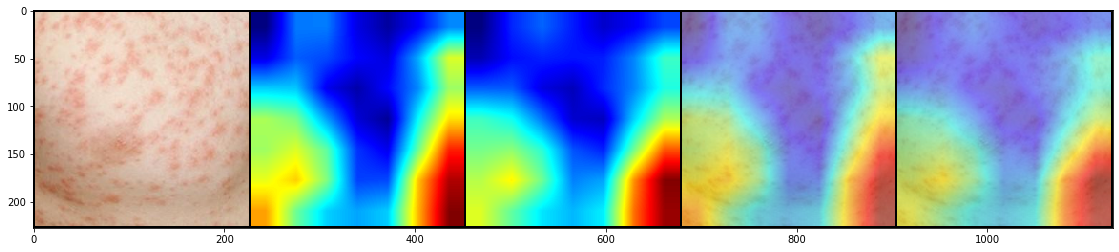

In [23]:
def saliency_image(cnn_models, layer_name, types, input_size = (224, 224)):
    pil_image = PIL.Image.open(df_main[df_main['label'] == 5][['filepath']].iloc[5, :][0])
    normalizer = Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    torch_img = torch.from_numpy(np.asarray(pil_image)).permute(2, 0, 1).unsqueeze(0).float().div(255)
    torch_img = F.upsample(torch_img, size = (224, 224), mode = 'bilinear', align_corners = False)
    normed_torch_img = normalizer(torch_img)
    
    cam_dict = dict()
    for model, layer, type in zip(cnn_models, layer_name, types):
        model_dict = dict(type = type, arch = model, layer_name = layer, input_size = input_size)
        model_grad = GradCAM(model_dict, True)
        model_capp = GradCAMpp(model_dict, True)
        cam_dict[type] = [model_grad, model_capp]

        images = []
        for gradcam, gradcam_pp in cam_dict.values():
            mask, _ = gradcam(normed_torch_img)
            heatmap, result = visualize_cam(mask, torch_img)
            mask_pp, _ = gradcam_pp(normed_torch_img)
            heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
            images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
        images = make_grid(torch.cat(images, 0), nrow = 5)
        return images

resnet = models.resnet152(pretrained = True).eval()
cnn_models, layer_name, types = [resnet], ['layer4'], ['resnet']
images = saliency_image(cnn_models, layer_name, types)
plt.figure(figsize = (40, 4))
plt.imshow(images.permute(1, 2, 0), interpolation = 'nearest')

saliency_map size : torch.Size([13, 13])
saliency_map size : torch.Size([13, 13])


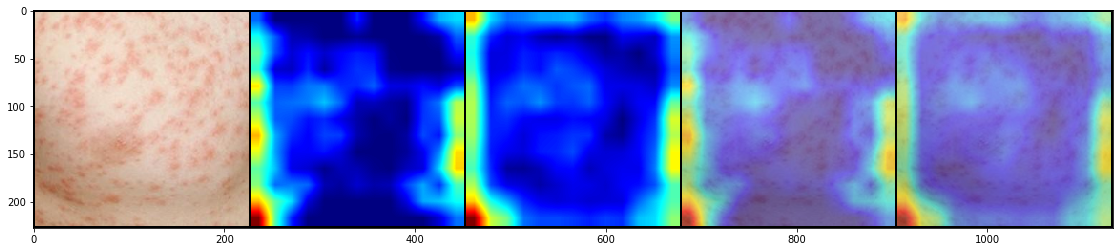

In [40]:
squeezenet  = models.squeezenet1_0(pretrained=True).eval()
cnn_models, layer_name, types = [squeezenet], ['features_11'], ['squeezenet']
images = saliency_image(cnn_models, layer_name, types)
plt.figure(figsize = (40, 4))
plt.imshow(images.permute(1, 2, 0), interpolation = 'nearest')

saliency_map size : torch.Size([13, 13])
saliency_map size : torch.Size([13, 13])


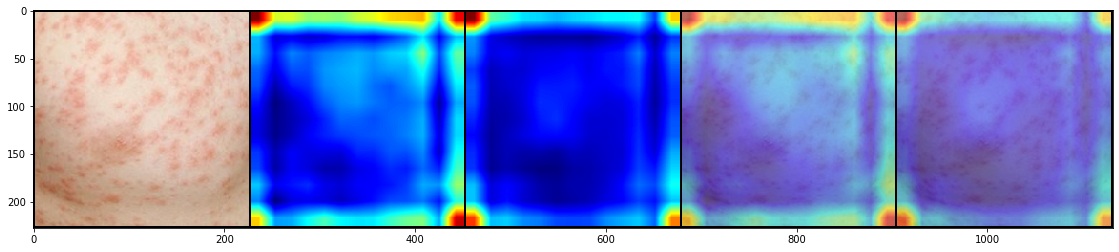

In [41]:
squeezenet  = models.alexnet(pretrained=True).eval()
cnn_models, layer_name, types = [squeezenet], ['features_11'], ['squeezenet']
images = saliency_image(cnn_models, layer_name, types)
plt.figure(figsize = (40, 4))
plt.imshow(images.permute(1, 2, 0), interpolation = 'nearest')

In [402]:
def count_parameters(model, print_all = True):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    if print_all:
        for item in params:
            print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  64,  3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)

        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,   6)
        
        self.dropout = nn.Dropout(p = 0.3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
count_parameters(BaselineCNN(), False)

________
 2568710


In [466]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import f1_score, confusion_matrix, auc


def get_metrics(predictions, labels):
    _, predictions = torch.max(predictions, 1)
    predictions = predictions.detach().numpy()
    labels = labels.detach().numpy()

    f1 = np.round(f1_score(labels, predictions, average = 'weighted'), 3)
    return {'f1': f1}

In [475]:
def multiclass_accuracy(preds, y):
    ''' 
    Arguments: 
        preds --> model output
        y     --> ground trutch
    Returns the accuracy of the model prediction
    '''
    _, preds = torch.max(preds, 1)
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def epoch_time(start_time, end_time):
    ''' 
    Arguments: 
        start_time 
        end_time   
    Returns the elapsed minute and seconds of model training
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def test_model(model, test_loader):
    ''' 
        Arguments:
            model: CNN model to be tested
            test_loader
        Returns:
            confusion matrix and classification report of the CNN model 
            using test_loader
    '''
    correct = 0
    total   = 0

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))
    print('Confusion Matrix:')
    print(confusion_matrix(labels, predicted))
    print('Classification Report:')
    print(classification_report(labels, predicted, target_names = ['CHP', 'CWP', 'HEALTHY', 'HFMD', 'MKP', 'MSL']))
    return predicted, labels

def train(num_epochs, model, train_loader, valid_loader, test_loader, optimizer, criterion, device, accuracy = True):
    ''' 
    Arguments:
        num_epochs: Number of epochs for model training and validation (usually 100 epochs)
        model: CNN model in PyTorch
        train_loader: Training   set (map-style dataset) implemented from DataLoader constructor
        valid_loader: Validation set (map-style dataset) implemented from DataLoader constructor
        test_loader:  Testing    set (map-style dataset) implemented from DataLoader constructor
        optimizer:  Optimization model for adjusting the model parameters to reduce model error in each training set
                    You may specify optimizer-specific options such as learning rate, weight decay, etc.
                    Usual values are: 
                        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
                        optimizer = optim.Adam([var1, var2], lr=0.0001)
        criterion: Loss function
        device: Location on which the tensor resides. If model training is on a local device without GPU, use 'cpu'.
                Otherwise, use 'cuda' especially using Google Colaboratory

        accuracy (boolean): If True, prints training and validation losses and accuracies
                            Otherwise, only training and validation losses
    Returns:
        train_losses, valid_losses: (lists) loss values of the model training and validation, respectively
        train_accurs, valid_accurs  (lists) accuracy values of training and validation, respectively
        test_loss, test_accu: (float) loss and accuracy values of testing
        train_metric, valid_metric: (dictionary) metrics from the get_metrics(prediction, label) function
        best_epoch: (int) epoch number with the best model (i.e., lowest loss and highest accuracy)
        epoch_times: (list) of epoch_mins and epoch_secs
        test_metric: (dictionary) metrics using testing set
        test_predictions: (list) Predictions of the model on a testing set
        best_model: (model) Best model version from the best_epoch
    '''
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    train_accurs, valid_accurs = [], []
    train_metric, valid_metric = [], []

    epoch_times = []
    list_best_epochs = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_accu, train_metr    = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accu, valid_metr, _ = _evals(model, valid_loader, criterion, device)
        
        if accuracy:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)}   \t Accuracy: {np.round(train_accu, 5)} \t Validation Loss  {np.round(valid_loss, 5)} \t Accuracy: {np.round(valid_accu, 5)}')
        else:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)} \t Validation Loss  {np.round(valid_loss, 5)}')
        
        train_losses.append(train_loss)
        train_accurs.append(train_accu)
        train_metric.append(train_metr)
        valid_losses.append(valid_loss)
        valid_accurs.append(valid_accu)
        valid_metric.append(valid_metr)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        list_best_epochs.append(best_epoch)
    test_loss, test_accu, test_metric, test_predictions  = _evals(best_model, test_loader, criterion, device)
    print(f'Final Best Model from Best Epoch {best_epoch + 1} Test Loss = {test_loss}, Test Accuracy = {test_accu}')
    return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model

def _train(model, train_loader, optimizer, criterion, device):
    ''' 
    Description: _train is used for every one epoch
    Arguments:
        model: CNN model and should be instantiated to the device location (i.e., 'cpu' or 'cuda')
        train_loader: Training dataset loaded in PyTorch's DataLoader 
        optimizer: Optimizing function to reduce the loss (usually Adam) 
        criterion: Loss function to evaluate the prediction and target at one epoch
        device: Location on which the tensor resides. If model training is on a local device without GPU, use 'cpu'.
                Otherwise, use 'cuda' especially using Google Colaboratory
    Returns:
        epoch_train_loss (float): Training loss at one epoch
        epoch_train_accu (float): Training accuracy at one epoch
        metric (dictionary): Training metrics based on the function get_metrics()
    '''
    model.train()
    epoch_train_loss = 0
    epoch_train_accu = 0

    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()
        epoch_train_loss += loss.item()
        
        accuracy = multiclass_accuracy(outputs, labels)
        metric   = get_metrics(outputs, labels)
        
        epoch_train_accu += accuracy.item()

    epoch_train_loss = epoch_train_loss / len(train_loader) 
    epoch_train_accu = epoch_train_accu / len(train_loader) 
    return epoch_train_loss, epoch_train_accu, metric

def _evals(model, valid_loader, criterion, device):
    ''' 
    Description: _evals is used for every one epoch for validation and testing
    Arguments:
        model: CNN model and should be instantiated to the device location (i.e., 'cpu' or 'cuda')
        valid_loader: Validation dataset loaded in PyTorch's DataLoader 
        optimizer: Optimizing function to reduce the loss (usually Adam), should be the same in _train 
        criterion: Loss function to evaluate the prediction and target at one epoch, should be the same in _train
        device: Location on which the tensor resides. If model training is on a local device without GPU, use 'cpu'.
                Otherwise, use 'cuda' especially using Google Colaboratory
    Returns:
        epoch_valid_loss (float): Validation loss at one epoch
        epoch_valid_accu (float): Validation accuracy at one epoch
        metric (dictionary): Training metrics based on the function get_metrics()
    '''
    model.eval()
    epoch_valid_loss = 0
    epoch_valid_accu = 0

    all_predictions = []

    with torch.no_grad():
        for id, data in enumerate(valid_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            all_predictions.extend(outputs)

            epoch_valid_loss += loss.item()
            accuracy = multiclass_accuracy(outputs, labels)
            metric   = get_metrics(outputs, labels)
            epoch_valid_accu += accuracy.item()
    epoch_valid_loss = epoch_valid_loss / len(valid_loader)
    epoch_valid_accu = epoch_valid_accu / len(valid_loader)
    return epoch_valid_loss, epoch_valid_accu, metric, all_predictions

def plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs):
    alpha = 0.3
    smoothed_train_losses = [train_losses[0]]
    smoothed_valid_losses = [valid_losses[0]]
    smoothed_train_accurs = [train_accurs[0]]
    smoothed_valid_accurs = [valid_accurs[0]]
    
    for i in range(1, len(train_losses)):
        smoothed_train_losses.append(alpha * train_losses[i] + (1-alpha) * smoothed_train_losses[-1])
        smoothed_valid_losses.append(alpha * valid_losses[i] + (1-alpha) * smoothed_valid_losses[-1])
        smoothed_train_accurs.append(alpha * train_accurs[i] + (1-alpha) * smoothed_train_accurs[-1])
        smoothed_valid_accurs.append(alpha * valid_accurs[i] + (1-alpha) * smoothed_valid_accurs[-1])
    
    smoothed_train_losses = train_losses
    smoothed_train_accurs = train_accurs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(smoothed_train_losses, label = 'Train')
    ax1.plot(smoothed_valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(smoothed_train_accurs, label='Train')
    ax2.plot(smoothed_valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()

In [280]:
model_alexnet = models.alexnet(pretrained = True).to(device)

for param in model_alexnet.parameters():
    param.requires_grad = False

torch.manual_seed(42)
model_alexnet.features[0] = torch.nn.Conv2d(3,  64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[2] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)
model_alexnet.features[3] = torch.nn.Conv2d(64, 192, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[5] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)

model_alexnet.classifier[6] = torch.nn.Linear(4096, 6)
model_alexnet.classifier[6].requires_grad = True

count_parameters(model_alexnet, print_all = False)

________
  137158


In [361]:
# 32 x 32 input shape
model_cnn = BaselineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(10, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 1.78977   	 Accuracy: 0.27801 	 Validation Loss  1.83747 	 Accuracy: 0.2375
Epoch: 2 	 Training: Loss 1.57241   	 Accuracy: 0.37015 	 Validation Loss  1.79793 	 Accuracy: 0.3
Epoch: 3 	 Training: Loss 1.41094   	 Accuracy: 0.39904 	 Validation Loss  1.67315 	 Accuracy: 0.3875
Epoch: 4 	 Training: Loss 1.27001   	 Accuracy: 0.5114 	 Validation Loss  1.77427 	 Accuracy: 0.31875
Epoch: 5 	 Training: Loss 1.34511   	 Accuracy: 0.46971 	 Validation Loss  1.63646 	 Accuracy: 0.3375
Epoch: 6 	 Training: Loss 1.21969   	 Accuracy: 0.50956 	 Validation Loss  1.64896 	 Accuracy: 0.4375
Epoch: 7 	 Training: Loss 1.19252   	 Accuracy: 0.5264 	 Validation Loss  1.76373 	 Accuracy: 0.36875
Epoch: 8 	 Training: Loss 1.16936   	 Accuracy: 0.52243 	 Validation Loss  1.78651 	 Accuracy: 0.4125
Epoch: 9 	 Training: Loss 1.09107   	 Accuracy: 0.58779 	 Validation Loss  1.88712 	 Accuracy: 0.36875
Epoch: 10 	 Training: Loss 0.98164   	 Accuracy: 0.62559 	 Validation Loss  1.94314 

In [383]:
# 64 x 64 input shape
model_cnn = BaselineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(10, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 3.38582   	 Accuracy: 0.26515 	 Validation Loss  2.48045 	 Accuracy: 0.175
Epoch: 2 	 Training: Loss 1.68719   	 Accuracy: 0.31846 	 Validation Loss  1.75074 	 Accuracy: 0.38125
Epoch: 3 	 Training: Loss 1.56345   	 Accuracy: 0.36676 	 Validation Loss  1.72516 	 Accuracy: 0.3375
Epoch: 4 	 Training: Loss 1.35115   	 Accuracy: 0.50191 	 Validation Loss  1.78121 	 Accuracy: 0.2875
Epoch: 5 	 Training: Loss 1.36073   	 Accuracy: 0.50301 	 Validation Loss  1.77785 	 Accuracy: 0.2625
Epoch: 6 	 Training: Loss 1.2585   	 Accuracy: 0.53059 	 Validation Loss  1.76678 	 Accuracy: 0.30625
Epoch: 7 	 Training: Loss 1.28945   	 Accuracy: 0.50015 	 Validation Loss  1.80388 	 Accuracy: 0.3
Epoch: 8 	 Training: Loss 1.12043   	 Accuracy: 0.59066 	 Validation Loss  1.85133 	 Accuracy: 0.29375
Epoch: 9 	 Training: Loss 1.09955   	 Accuracy: 0.56074 	 Validation Loss  1.98944 	 Accuracy: 0.2625
Epoch: 10 	 Training: Loss 1.02432   	 Accuracy: 0.60853 	 Validation Loss  2.20093 

In [371]:
# 128 x 128 input shape
model_cnn = BaselineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(10, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 12.97062   	 Accuracy: 0.24074 	 Validation Loss  4.36076 	 Accuracy: 0.25
Epoch: 2 	 Training: Loss 2.45762   	 Accuracy: 0.27699 	 Validation Loss  1.96649 	 Accuracy: 0.1875
Epoch: 3 	 Training: Loss 1.708   	 Accuracy: 0.32757 	 Validation Loss  1.81699 	 Accuracy: 0.3125
Epoch: 4 	 Training: Loss 1.60715   	 Accuracy: 0.35654 	 Validation Loss  1.79373 	 Accuracy: 0.2625
Epoch: 5 	 Training: Loss 1.52901   	 Accuracy: 0.36625 	 Validation Loss  1.87289 	 Accuracy: 0.24375
Epoch: 6 	 Training: Loss 1.57143   	 Accuracy: 0.35338 	 Validation Loss  1.7638 	 Accuracy: 0.275
Epoch: 7 	 Training: Loss 1.50171   	 Accuracy: 0.40985 	 Validation Loss  1.81072 	 Accuracy: 0.24375
Epoch: 8 	 Training: Loss 1.52293   	 Accuracy: 0.35103 	 Validation Loss  1.72845 	 Accuracy: 0.34375
Epoch: 9 	 Training: Loss 1.43434   	 Accuracy: 0.41846 	 Validation Loss  1.90037 	 Accuracy: 0.2375
Epoch: 10 	 Training: Loss 1.38438   	 Accuracy: 0.44529 	 Validation Loss  1.89716 

In [393]:
model_vgg16 = torchvision.models.vgg16(weights = True).to(device)

for param in model_vgg16.parameters():
    param.requires_grad = False

torch.manual_seed(42)
model_vgg16.classifier[-1] = torch.nn.Linear(4096, 6)
count_parameters(model_vgg16, print_all = False)

train_losses_vgg16, valid_losses_vgg16, train_accurs_vgg16, valid_accurs_vgg16, test_loss_vgg16, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric_vgg16, test_predictions, best_model = train(10, model_vgg16, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 2.03462   	 Accuracy: 0.21081 	 Validation Loss  1.97783 	 Accuracy: 0.13125
Epoch: 2 	 Training: Loss 2.09774   	 Accuracy: 0.17037 	 Validation Loss  1.8514 	 Accuracy: 0.2625
Epoch: 3 	 Training: Loss 2.09024   	 Accuracy: 0.17537 	 Validation Loss  1.88391 	 Accuracy: 0.1625
Epoch: 4 	 Training: Loss 2.07337   	 Accuracy: 0.1914 	 Validation Loss  2.02184 	 Accuracy: 0.125
Epoch: 5 	 Training: Loss 2.10932   	 Accuracy: 0.19272 	 Validation Loss  1.84614 	 Accuracy: 0.2625
Epoch: 6 	 Training: Loss 2.12118   	 Accuracy: 0.19088 	 Validation Loss  1.87092 	 Accuracy: 0.2125
Epoch: 7 	 Training: Loss 2.11862   	 Accuracy: 0.15882 	 Validation Loss  1.93884 	 Accuracy: 0.175
Epoch: 8 	 Training: Loss 2.0799   	 Accuracy: 0.19926 	 Validation Loss  1.93663 	 Accuracy: 0.1875
Epoch: 9 	 Training: Loss 2.0929   	 Accuracy: 0.17618 	 Validation Loss  1.84202 	 Accuracy: 0.26875
Epoch: 10 	 Training: Loss 2.05925   	 Accuracy: 0.17985 	 Validation Loss  1.98905 	 

In [404]:
# 32 x 32 input shape
model_cnn = BaselineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(10, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 1.77714   	 Accuracy: 0.19743 	 Validation Loss  1.79395 	 Accuracy: 0.175
Epoch: 2 	 Training: Loss 1.76212   	 Accuracy: 0.19213 	 Validation Loss  1.76453 	 Accuracy: 0.21875
Epoch: 3 	 Training: Loss 1.71681   	 Accuracy: 0.31213 	 Validation Loss  1.77038 	 Accuracy: 0.35
Epoch: 4 	 Training: Loss 1.71597   	 Accuracy: 0.3114 	 Validation Loss  1.76876 	 Accuracy: 0.2625
Epoch: 5 	 Training: Loss 1.68945   	 Accuracy: 0.31191 	 Validation Loss  1.80096 	 Accuracy: 0.24375
Epoch: 6 	 Training: Loss 1.65962   	 Accuracy: 0.345 	 Validation Loss  1.77909 	 Accuracy: 0.2875
Epoch: 7 	 Training: Loss 1.63035   	 Accuracy: 0.35941 	 Validation Loss  1.76047 	 Accuracy: 0.3
Epoch: 8 	 Training: Loss 1.64507   	 Accuracy: 0.35441 	 Validation Loss  1.77672 	 Accuracy: 0.30625
Epoch: 9 	 Training: Loss 1.60648   	 Accuracy: 0.39301 	 Validation Loss  1.83996 	 Accuracy: 0.25
Epoch: 10 	 Training: Loss 1.59248   	 Accuracy: 0.38831 	 Validation Loss  1.75264 	 Accu

In [477]:
model_cnn = BaselineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(10, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)
predictions, labels = test_model(model_cnn, test_loader)

Test Accuracy: 61.27%
Confusion Matrix:
[[5 0 0 0 0 1]
 [1 4 0 0 0 0]
 [0 0 7 1 0 0]
 [0 0 0 2 0 1]
 [1 0 0 0 0 0]
 [0 0 0 0 0 2]]
Classification Report:
              precision    recall  f1-score   support

         CHP       0.71      0.83      0.77         6
         CWP       1.00      0.80      0.89         5
     HEALTHY       1.00      0.88      0.93         8
        HFMD       0.67      0.67      0.67         3
         MKP       0.00      0.00      0.00         1
         MSL       0.50      1.00      0.67         2

    accuracy                           0.80        25
   macro avg       0.65      0.70      0.65        25
weighted avg       0.81      0.80      0.79        25



### Proposed Model: ResNet with Bottle Neck constraint + Squeeze and Excitation module

In [491]:
class BottleneckBlock(nn.Module):
    EXPANSION = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.EXPANSION * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.EXPANSION * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.EXPANSION * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.EXPANSION * planes,
                          kernel_size=1, stride = stride, bias = False),
                nn.BatchNorm2d(self.EXPANSION * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet50(num_classes = 10):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)
model_resnet = ResNet50().to(device)
count_parameters(model_resnet, print_all = False)

________
23520842


In [493]:
# 64 x 64 input shape
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(10, model_resnet, train_loader, valid_loader, test_loader, optimizer, criterion, device)

In [539]:
np.random.uniform(0.05, 0.1, 1)[0]

0.0960710519067264